In this notebook we will
+ Fetch historical data
+ Plot the data
+ Resample the data
+ Run a simple indicator on it

In [45]:
from binance import Client
import pandas as pd
import yfinance as yf
import mplfinance as mpf
import talib

## Here is how we can fetch bitcoin data from Binance

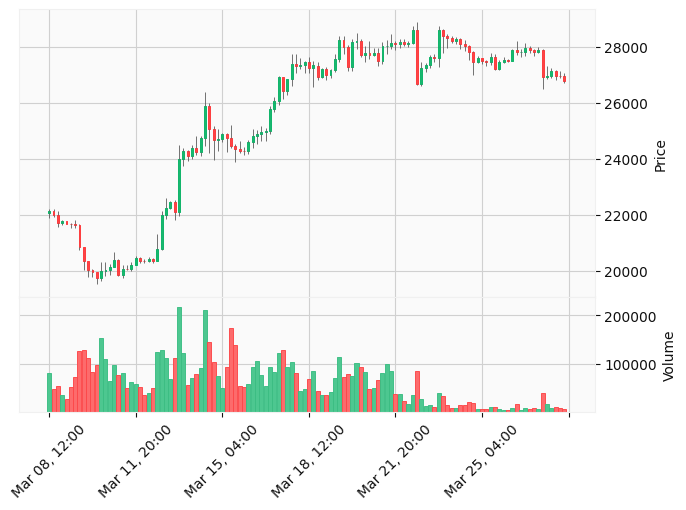

In [53]:
client = Client()

# Define the symbol and time interval for the OHLC data
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_4HOUR
ago = "20 days ago"

def get_crypto_data(symbol, interval, ago):
    # Get the OHLC data from the Binance API
    klines = client.get_historical_klines(symbol, interval, ago)

    # Convert the data to a Pandas DataFrame
    data = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'num_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

    # Convert the timestamp to a readable date format
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

    # Set the timestamp as the DataFrame index
    data.set_index('timestamp', inplace=True)
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")
        data.dropna(subset=[col], inplace=True)

    # Rename all columns to upper case on first letter only
    data.columns = data.columns.str.title()
    return data



btc = get_crypto_data(symbol, interval, ago)
mpf.plot(btc, type='candle', volume=True, style="yahoo")

## Here is how we can fetch stock data from Yahoo

[*********************100%***********************]  1 of 1 completed


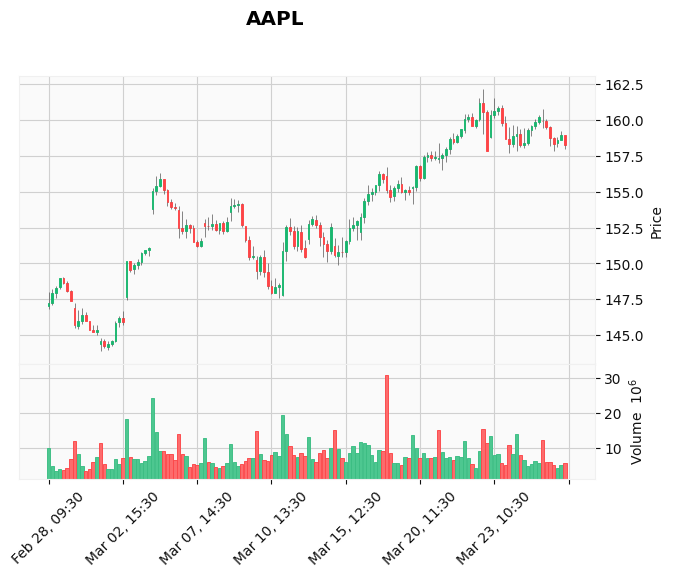

In [43]:
# Download historical stock price data for Apple (AAPL) from 2010 to 2022
aapl = yf.download('AAPL', interval='1h', period='1mo')

mpf.plot(aapl, type='candle', volume=True, style='yahoo', title='AAPL')

## Let use resample the data to 4H

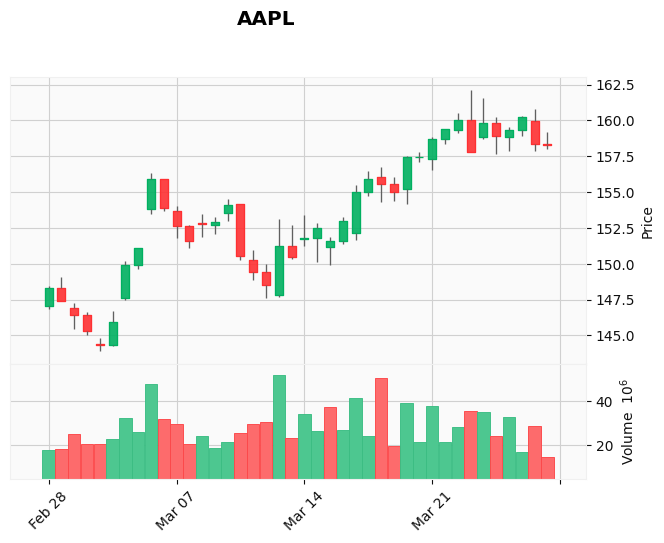

In [44]:
# Resample the data to hourly
aapl_4h = aapl.resample('4H').agg({'Open': 'first', 
                                    'High': 'max', 
                                    'Low': 'min', 
                                    'Close': 'last', 
                                    'Volume': 'sum'})

aapl_4h.dropna(inplace=True) # Drop NA in order to account for gaps when market is closed

mpf.plot(aapl_4h, type='candle', volume=True, style='yahoo', title='AAPL', warn_too_much_data=1000000)

## Now, let use add some basic moving averages. We will also show the crossover

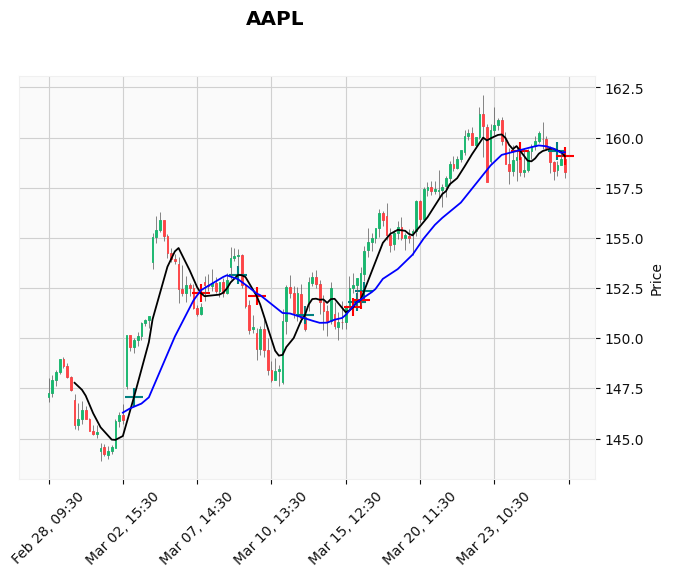

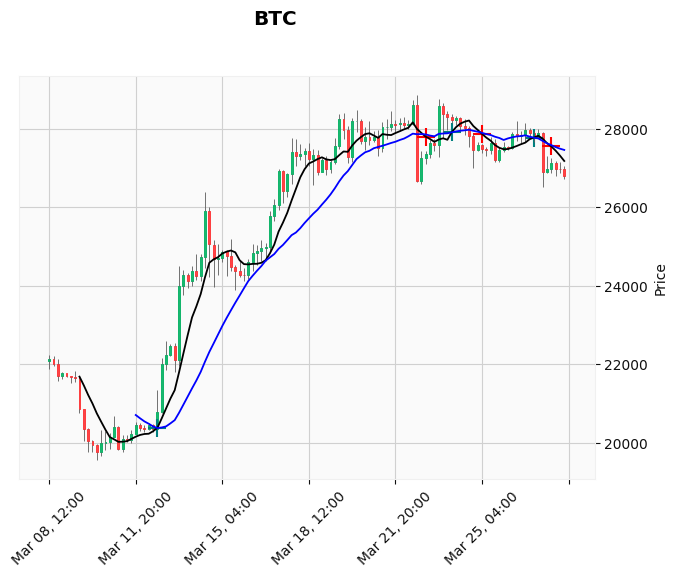

In [84]:
def has_cross_above(df1, df2):
    return (df1 > df2) & (df1.shift(1) <= df2.shift(1))

def has_cross_below(df1, df2):
    return (df1 < df2) & (df1.shift(1) >= df2.shift(1))

def plot(data, title):
    # We create 2 moving averages and display them on 
    sma = talib.SMA(data.Close, timeperiod=8)
    sma_long = talib.SMA(data.Close, timeperiod=21)
    cross_below = has_cross_below(sma, sma_long)
    cross_above = has_cross_above(sma, sma_long)

    up = pd.DataFrame(
        {"entry": sma[cross_above], "value": 1}, index=cross_above.index
    )
    down = pd.DataFrame(
        {"entry": sma[cross_below], "value": 1}, index=cross_below.index
    )


    mpf.plot(
        data,
        type="candle",
        volume=False,
        style="yahoo",
        title=title,
        addplot=[
            mpf.make_addplot(sma, panel=0, color="black"),
            mpf.make_addplot(sma_long, panel=0, color="blue"),
            mpf.make_addplot(
                up["entry"],
                type="scatter",
                panel=0,
                color="teal",
                markersize=150,
                marker="+"
            ),
            mpf.make_addplot(
                down["entry"],
                type="scatter",
                panel=0,
                color="red",
                markersize=150,
                marker="+"
            ),
        ],
    )

plot(aapl, "AAPL")
plot(btc, "BTC")